In [21]:
# Essential Imports
import numpy as np
import torch
import matplotlib.pyplot as plt

In [22]:
# Local imports
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files
from scnn import SNN
from scnn.optim import RAdam

In [23]:
# Tools Import
from data.data_augmentor import data_augment, batchify

In [24]:
batch_size = 16
nb_epochs = 2

In [25]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

In [26]:
# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    print('remove this')
    trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=20
    )

# calculate train dataset size
dataset_size = 0.
for x_batch, y_batch in load_data('train'):
    dataset_size += 1.
    if dataset_size % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size, end='')
print('\rpre-processing dataset: %d' % dataset_size)

remove this
pre-processing dataset: 137


In [27]:
%matplotlib inline

from matplotlib.gridspec import GridSpec

def plot_spikes_in_time(layer, batch_id=0):
    if layer.IS_CONV:
        _plot_spikes_conv(layer, batch_id)
    else:
        _plot_spikes_dense(layer, batch_id)


def _plot_spikes_dense(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    for i in range(mem_rec_hist.shape[1]):
        plt.plot(mem_rec_hist[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    
    plt.show()
    plt.plot(spk_rec_hist,'b.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(spk_rec_hist)
    plt.xlabel('Neuron')
    plt.ylabel('Spike Time')
    plt.axis([-1, spk_rec_hist.shape[1], -1, spk_rec_hist.shape[0]])
    plt.show()
    

def _plot_spikes_conv(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    time_step = mem_rec_hist.shape[1]
    channels = mem_rec_hist.shape[0]
    rest_shape = mem_rec_hist.shape[2:]
    
    tmp_spk = np.zeros((time_step, channels, *rest_shape))
    tmp_mem = np.zeros((time_step, channels, *rest_shape))
    for i in range(time_step):
        tmp_spk[i, :, :, :] = spk_rec_hist[:, i, :, :]
        tmp_mem[i, :, :, :] = mem_rec_hist[:, i, :, :]
    spk_rec_hist = tmp_spk
    mem_rec_hist = tmp_mem
    
    flat_spk = np.reshape(spk_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    flat_mem = np.reshape(mem_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    
    # Plot Flats
    max_flats = 25
    if flat_mem.shape[1] > max_flats:
        inx = np.random.randint(flat_mem.shape[1], size=max_flats)
        flat_spk = flat_spk[:, inx]
        flat_mem = flat_mem[:, inx]
    
    for i in range(flat_mem.shape[1]):
        plt.plot(flat_mem[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    plt.show()
    
    plt.plot(flat_spk,'.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(flat_spk, cmap=plt.cm.gray_r, origin="lower", aspect='auto')
    plt.xlabel('Neuron')
    plt.ylabel ('Spike Time')
    plt.axis([-1, flat_spk.shape[1], -1, flat_spk.shape[0]])
    plt.show()
    
    # Visual Plots
    max_visual = 5
    
#     debug_print(spk_rec_hist, 'spk', pytorch=False)
#     debug_print(mem_rec_hist, 'mem', pytorch=False)

    time_idx = list(range(0, time_step, int(time_step/max_visual)))
    neur_idx = np.random.randint(mem_rec_hist.shape[1], size=max_visual)

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

#     counter = 0
#     for n in neur_idx:
#         for t in time_idx:
#             if counter == 0:
#                 a0 = ax = plt.subplot(gs[counter])
#             else:
#                 ax = plt.subplot(gs[counter], sharey=a0)
#             ax.imshow(spk_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
#             plt.title('t(%d) - n(%d)' % (t, n))
#             counter += 1
#     plt.show()
    
    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    counter = 0
    for n in neur_idx:
        for t in time_idx:
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(mem_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
            plt.title('t(%d) - n(%d)' % (t, n))
            counter += 1

In [35]:
import torch

from scnn.conv1d import SpikingConv1DLayer
from scnn.conv2d import SpikingConv2DLayer
from scnn.conv3d import SpikingConv3DLayer
from scnn.pool2d import SpikingPool2DLayer
from scnn.dense import SpikingDenseLayer
from scnn.readout import ReadoutLayer
from scnn.heaviside import SurrogateHeaviside

import torch
import numpy as np


class SNN(torch.nn.Module):
    def __init__(self, spike_fn=None, device=None, dtype=None, time_expector=None, notifier=None):
        super(SNN, self).__init__()
        self.layers = []
        self.default_spike_fn = spike_fn if spike_fn is not None else SurrogateHeaviside.apply
        self.last_layer_shape = None
        self.last_layer_is_conv = None
        self.time_expector = time_expector
        self.notifier = notifier
        self.dtype = torch.float if dtype is None else dtype
        if device is None:
            self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        else:
            self.device = device
        self.to(device, dtype)

    def get_trainable_parameters(self):
        res = []
        for l in self.layers:
            res.extend(l.get_trainable_parameters())
        return res

    def add_conv1d(self, **kwargs):
        self.add_layer(SpikingConv1DLayer, **kwargs)

    def add_conv2d(self, **kwargs):
        self.add_layer(SpikingConv2DLayer, **kwargs)

    def add_conv3d(self, **kwargs):
        self.add_layer(SpikingConv3DLayer, **kwargs)

    def add_pool2d(self, **kwargs):
        self.add_layer(SpikingPool2DLayer, **kwargs)

    def add_dense(self, **kwargs):
        self.add_layer(SpikingDenseLayer, **kwargs)

    def add_readout(self, **kwargs):
        self.add_layer(ReadoutLayer, **kwargs)

    def add_layer(self, layer, **kwargs):
        if layer.IS_SPIKING and self.default_spike_fn is not None and 'spike_fn' not in kwargs:
            kwargs['spike_fn'] = self.default_spike_fn

        if not layer.IS_CONV and self.last_layer_is_conv:
            self.layers[-1].flatten_output = True

        # calculating this layer inputs based on last layer
        if self.last_layer_shape is not None:
            llsh = self.last_layer_shape
            if layer.IS_CONV and 'input_channels' not in kwargs and 'input_shape' not in kwargs:
                if self.last_layer_is_conv:
                    kwargs['input_channels'] = llsh['channels']
                    kwargs['input_shape'] = llsh['shape']
                else:
                    raise NotImplementedError()  # FIXME : handle if last layer was not conv
            elif not layer.IS_CONV and 'input_shape' not in kwargs:
                if self.last_layer_is_conv:
                    input_shape = 1
                    for i in range(len(llsh['shape'])):
                        input_shape *= llsh['shape'][i]
                    input_shape *= llsh['channels']
                    kwargs['input_shape'] = input_shape
                else:
                    kwargs['input_shape'] = llsh['shape']

        new_layer = layer(**kwargs)
        if new_layer.IS_CONV:
            self.last_layer_shape = {'channels': new_layer.output_channels, 'shape': new_layer.output_shape}
        else:
            self.last_layer_shape = {'shape': new_layer.output_shape}

        self.layers.append(new_layer)
        self.last_layer_is_conv = layer.IS_CONV

    def compile(self):
        self.layers = torch.nn.ModuleList(self.layers)

    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        shp = x.shape
        if self.layers[0].IS_CONV:
            x = x.view(shp[0], 1, shp[1], shp[2], shp[3])
        else:
            x = x.view(shp[0], shp[1], shp[2] * shp[3])
        x = x.to(self.device, self.dtype)
        return self.forward(x)

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def clamp(self):
        for l in self.layers:
            l.clamp()

    def reset_parameters(self):
        for l in self.layers:
            l.reset_parameters()

    def fit(self, data_loader, epochs=5, loss_func=None, optimizer=None, dataset_size=None):
        # fix params before proceeding
        if loss_func is None:
            loss_func = torch.nn.NLLLoss()
        if dataset_size is None:
            dataset_size = 0.
            for _, _ in data_loader('train'):
                dataset_size += 1.
                if dataset_size % 64 == 1:
                    print('\rpre-processing dataset: %d' % dataset_size, end='')
            print('\rpre-processing dataset: %d' % dataset_size)
        if optimizer is None:
            optimizer = torch.optim.SGD(self.get_trainable_parameters(), lr=0.1, momentum=0.9)

        # train code
        for epoch in range(epochs):
            if self.time_expector is not None:
                self.time_expector.tick(epochs - epoch)

            # train
            dataset_counter = 0
            self.train()
            losses = []
            nums = []
            for x_batch, y_batch in data_loader('train'):
                dataset_counter += 1
                self.print_progress('Epoch: %d' % epoch, dataset_counter / dataset_size, width=60)
                l, n = self.batch_step(loss_func, x_batch, y_batch, optimizer)
                losses.append(l)
                nums.append(n)
            train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

            # evaluate
            self.eval()
            with torch.no_grad():
                losses = []
                nums = []
                for x_batch, y_batch in data_loader('test'):
                    l, n = self.batch_step(loss_func, x_batch, y_batch)
                    losses.append(l)
                    nums.append(n)
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

            # finishing up
            print("  | loss=%.3f val_loss=%.3f" % (train_loss, val_loss))

            train_accuracy = self.compute_classification_accuracy(data_loader('acc_train'))
            valid_accuracy = self.compute_classification_accuracy(data_loader('acc_test'))
            print('train_accuracy=%.2f%%  |  valid_accuracy=%.2f%%' % (train_accuracy * 100., valid_accuracy * 100.))

            if self.time_expector is not None:
                self.time_expector.tock()

    def batch_step(self, loss_func, xb, yb, opt=None):
        log_softmax_fn = torch.nn.LogSoftmax(dim=1)  # TODO: investigate this
        yb = torch.from_numpy(yb.astype(np.long)).to(self.device)

        y_pred = self.predict(xb)
        log_y_pred = log_softmax_fn(y_pred)
        loss = loss_func(log_y_pred, yb)

        if opt is not None:
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.parameters(), 5)  # TODO: investigate this
            opt.step()
            self.clamp()  # TODO: investigate this
            opt.zero_grad()

        return loss.item(), len(xb)

    def compute_classification_accuracy(self, data_dl):
        accs = []
        with torch.no_grad():
            for x_batch, y_batch in data_dl:
                output = self.predict(x_batch)
                y_batch = torch.from_numpy(y_batch.astype(np.long)).to(self.device)
                _, am = torch.max(output, 1)  # argmax over output units
                tmp = np.mean((y_batch == am).detach().cpu().numpy())  # compare to labels
                accs.append(tmp)
        return np.mean(accs)

    @staticmethod
    def print_progress(msg, value, width=80, a='=', b='>', c='.'):
        print('\r%s [%s%s%s] %d%%' % (msg, a*int(value*width), b, c*int((1.-value)*width), value*100), end='')



In [36]:
network = SNN(device=device, dtype=dtype)


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)


# network.add_layer(NewSpiker,
#     input_shape=4096,
#     output_shape=128,
                  
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_conv3d(input_shape=(64,64),
                   output_shape=(64,64),
                   input_channels=1,
                   output_channels=128,
                   kernel_size=(1,5,5),
                   dilation=(1,1,1),
                   lateral_connections=False,
)

# network.add_layer(SpikingPool2DLayer, kernel_size=(2,2), output_channels=32)
network.add_pool2d(kernel_size=(4,4), output_channels=128)


# network.add_dense(
#     input_shape=4096,
#     output_shape=256,
#    w_init_mean=0.006,
# #     w_init_std=.96,
#     lateral_connections=True
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

remove this
remove this
Train accuracy=0.043
remove this
Test accuracy=0.043
Layer 0: average number of spikes=0.0466


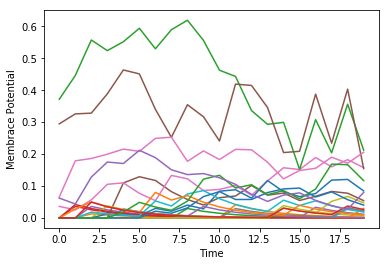

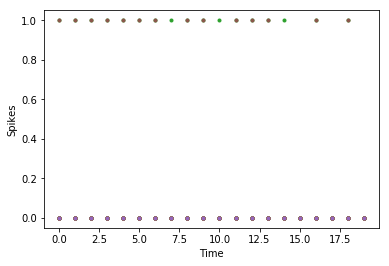

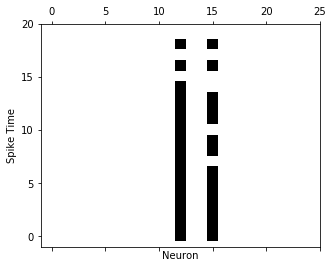

Layer 1: average number of spikes=0.0987


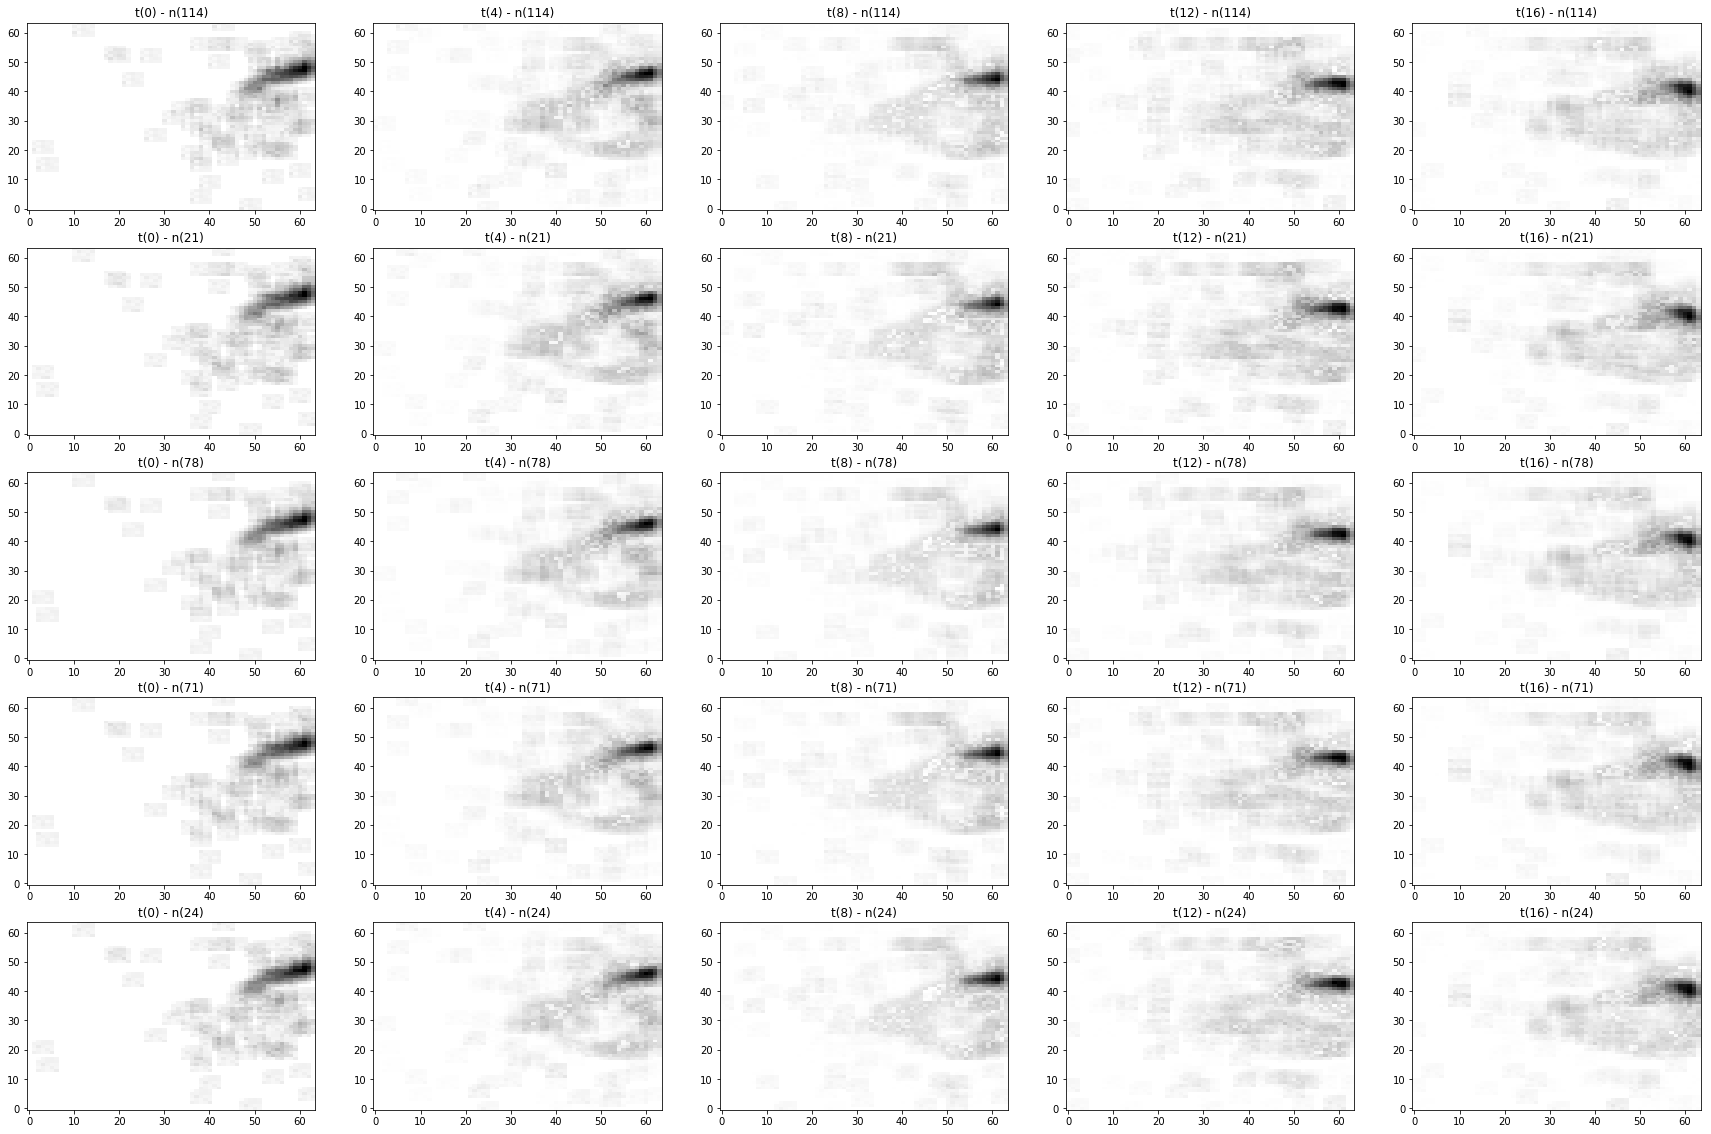

In [39]:
for X_batch, _ in load_data('train'):
    break

network.predict(X_batch)

for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        if l.HAS_PARAM:
            plot_spikes_in_time(l)

In [40]:
lr = 1e-3

# opt = RAdam(network.get_trainable_parameters())
opt = torch.optim.SGD(network.get_trainable_parameters(), lr=lr, momentum=0.9)
network.fit(load_data, optimizer=opt, dataset_size=dataset_size)

print('\n----------------------------------------')
train_accuracy = network.compute_classification_accuracy(load_data('train'))
print("Final Train Accuracy=%.2f%%"%(train_accuracy * 100.))
test_accuracy = network.compute_classification_accuracy(load_data('test'))
print("Final Test Accuracy=%.2f%%"%(test_accuracy * 100.))

remove this
Epoch: 0 [============================================================>] 100%remove this
  | loss=2.471 val_loss=2.456
remove this
remove this
train_accuracy=20.67%  |  valid_accuracy=20.67%
remove this
Epoch: 1 [============================================================>] 100%remove this
  | loss=2.442 val_loss=2.430
remove this
remove this
train_accuracy=20.57%  |  valid_accuracy=20.57%
remove this
Epoch: 2 [=>..........................................................] 2%

KeyboardInterrupt: 

remove this
Layer 0: average number of spikes=0.0458


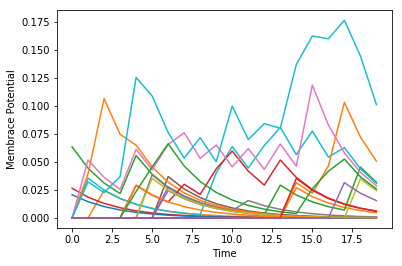

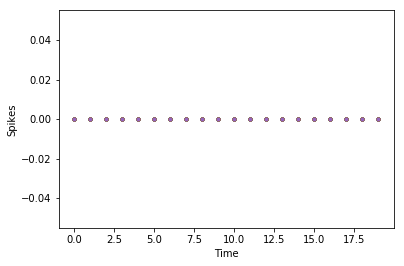

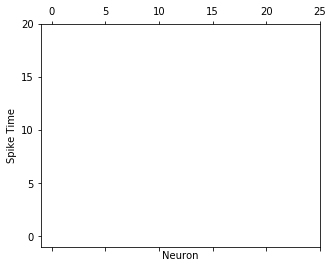

Layer 1: average number of spikes=0.1059


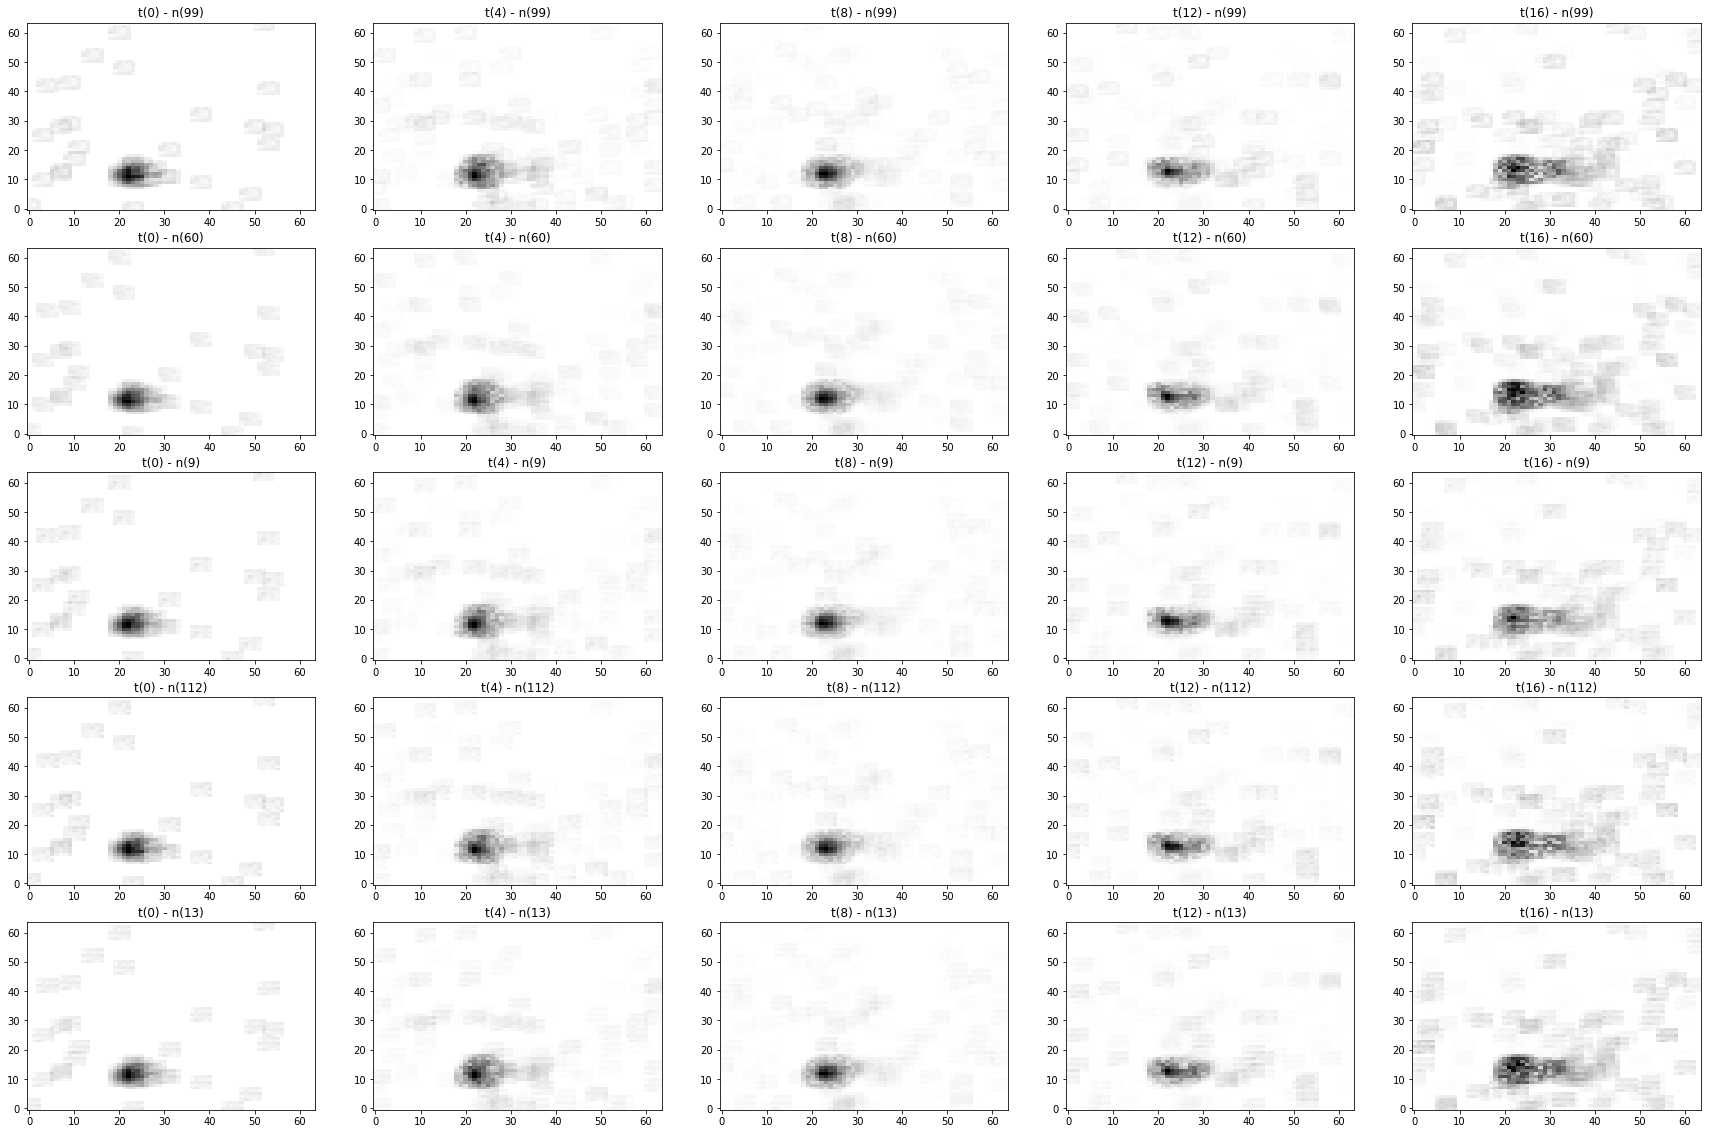

In [42]:
for X_batch, _ in load_data('train'):
    break

network.predict(X_batch)
for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        if l.HAS_PARAM:
            plot_spikes_in_time(l)

In [43]:
network(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(network.layers):
    if not l.HAS_PARAM:
        continue
        
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, 0)

TypeError: conv3d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray